## Packages

In [1]:
import pandas as pd
import numpy as np

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    roc_curve, 
    roc_auc_score, 
    confusion_matrix,
    accuracy_score,
    classification_report
)

import matplotlib.pyplot as plt
import seaborn as sns

## Goal
In this notebook, we will be looking at a classification problem of detecting online payments fraud online.

## Data

The goal is to predict the isFraud column.

Original Dataset: https://www.kaggle.com/datasets/vardhansiramdasu/fraudulent-transactions-prediction?sort=published

|Variable |	Description|
|:---------|:-------------|
|step |maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation)|
|type| type of online transaction. CASH-IN, CASH-OUT, DEBIT, PAYMENT, TRANSFER
|amount| the amount of the transaction in local currency
|nameOrig| customer starting the transaction
|oldbalanceOrg| balance before the transaction of the customer starting the transaction
|newbalanceOrig| balance after the transaction of the customer starting the transaction
|nameDest| recipient of the transaction
|oldbalanceDest| initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
|newbalanceDest| new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
|isFraud| This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system. 1 for Fraud
|isFlaggedFraud|The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.|

In [2]:
class OPF_data: 
    
    def __init__(self, filename='./online_payment_fraud_data.csv', test_size=0.2):
        
        data = pd.read_csv(filename)
        
        test = data['isFraud']
        train = data.loc[:,data.columns!='isFraud']
        
        self.X_train,self.X_test,self.y_train,self.y_test = train_test_split(
            train,
            test,
            test_size=test_size,
            random_state=42
        )
        
data = OPF_data(test_size=0.2)
X_train,y_train = data.X_train,data.y_train
X_test,y_test = data.X_test, data.y_test

## EDA

#### First I am going to inspect the data, looking at number of features, the data type of the features, size of the data, if there any any missing values

In [3]:
# Aesthetic settings for printing the tables
pd.set_option('display.float_format','{:,.0f}'.format)

# global variables
FIGSIZE=(8,6)

In [4]:
X_train.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud
6271196,619,CASH_IN,"386,385",C421351828,"4,669,569","5,055,954",C1977099364,"506,035","119,650",0
1888243,164,CASH_IN,"212,459",C83569848,"234,635","447,094",C1690589535,"806,038","593,579",0
5549957,382,PAYMENT,"19,968",C852995095,"3,634",0,M1695416333,0,0,0
2025342,180,CASH_OUT,"527,617",C61761046,"180,216",0,C577654587,"92,157","619,774",0
682342,36,TRANSFER,"206,068",C758004147,0,0,C2143015292,"2,131,494","2,337,562",0


In [5]:
print('Training Data')
print(f'Features: {X_train.shape[1]:,}')
print(f'Data Points: {X_train.shape[0]:,}')

Training Data
Features: 10
Data Points: 5,090,096


In [6]:
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5090096 entries, 6271196 to 1692743
Data columns (total 10 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFlaggedFraud    int64
dtypes: float64(5), int64(2), object(3)
memory usage: 427.2+ MB
None


In [7]:
# Taking a look at some stats on the data
X_train.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud
count,"5,090,096","5,090,096","5,090,096","5,090,096","5,090,096","5,090,096","5,090,096"
mean,243,"179,758","833,389","854,564","1,099,593","1,223,768",0
std,142,"601,618","2,886,947","2,922,632","3,391,912","3,666,375",0
min,1,0,0,0,0,0,0
25%,156,"13,396",0,0,0,0,0
50%,239,"74,865","14,181",0,"132,690","214,518",0
75%,335,"208,645","107,306","144,178","941,759","1,111,015",0
max,743,"92,445,517","59,585,040","49,585,040","356,015,889","356,179,279",1


From the above, note that there are transaction with 0 amount which is weird for a bank transaction.

In [8]:
# Quick inspection of the non-numerical columns 
X_train.describe(include='object')

,type,nameOrig,nameDest
count,5090096,5090096,5090096
unique,5,5084151,2265727
top,CASH_OUT,C545315117,C1286084959
freq,1790588,3,91


Notice the above, there are almost twice as many more source destination than recipients.

In [9]:
# Check for null values
nulls = X_train.isnull().sum()
nulls

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFlaggedFraud    0
dtype: int64

From above, there does not appear to be any null values

#### Next we are going to do so visualization and aggregation to extract some more information on the data

In [10]:
# Let's first look at what percentage of our data is fraud
print(f'Fraud Percentage: {y_train.sum()/y_train.shape[0]*100:0.2f}%')

Fraud Percentage: 0.13%


We see a very low percentage of the data is actually fraud. We may need to do some class balancing for this.

#### Evaluation of Numerical features

In [12]:
numerical_features = X_train.select_dtypes(exclude='object').columns.tolist()
# Manually remove isFlaggedFraud as this is a categorical variable
numerical_features.remove('isFlaggedFraud')
print('Numerical Features:',numerical_features)

Numerical Features: ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']


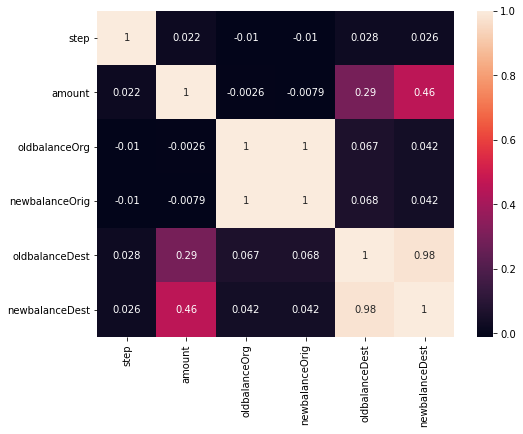

In [13]:
# Compute the correlation iteratively for faster computation
corr_matrix = []
for col1 in numerical_features:
    corr = []
    for col2 in numerical_features:
        corr.append(X_train[col1].corr(X_train[col2]))
    corr_matrix.append(corr)

# Correlation matrix plot 
plt.figure(figsize=FIGSIZE)
sns.heatmap(
    corr_matrix,
    annot=True,
    xticklabels=numerical_features,
    yticklabels=numerical_features
)
plt.show();

From the above correlation matrix we can near perfect relationships between oldbanaceOrg with newbalanceOrig and oldbalanceDest with newbalanceDest. Intuitively this should be now surprise. This suggests though, we may be able to exclude one of each columns as they dependent on one another. 

In [14]:
# For each numerical column, lets see if fraud activities have an impact 
# on statistics of each variable
# First preparing the data
isFraud = y_train == 1
tmp_data = X_train.join(y_train)

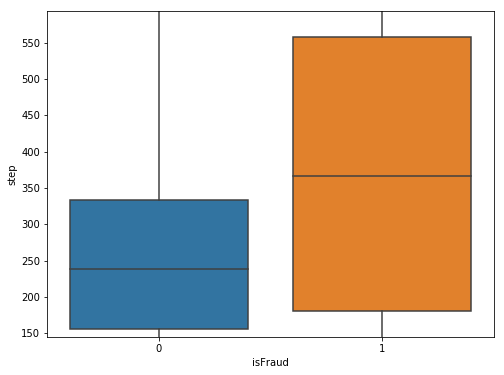

In [15]:
# Plot Step 
col = 'step'
plt.figure(figsize=FIGSIZE)
sns.boxplot(data=tmp_data,x='isFraud',y=col)
plt.ylim(
    tmp_data.loc[isFraud,col].quantile(0.2),
    tmp_data.loc[isFraud,col].quantile(0.8)
)
plt.show();

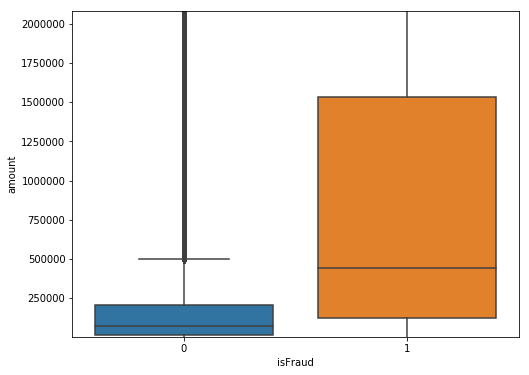

In [16]:
# Plot Step 
col = 'amount'
plt.figure(figsize=FIGSIZE)
sns.boxplot(data=tmp_data,x='isFraud',y=col)
plt.ylim(
    tmp_data.loc[~isFraud,col].quantile(0.1),
    tmp_data.loc[isFraud,col].quantile(0.8)
)
plt.show();

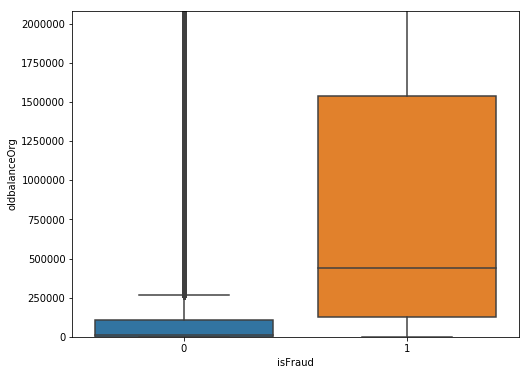

In [17]:
# Plot Step 
col = 'oldbalanceOrg'
plt.figure(figsize=FIGSIZE)
sns.boxplot(data=tmp_data,x='isFraud',y=col)
plt.ylim(
    tmp_data.loc[~isFraud,col].quantile(0.2),
    tmp_data.loc[isFraud,col].quantile(0.8)
)
plt.show();

/Users/dominicjo/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/matplotlib/pyplot.py:1479: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ret = ax.set_ylim(*args, **kwargs)


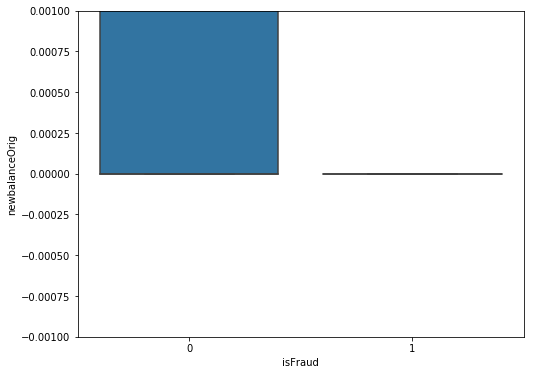

In [18]:
# Plot Step 
col = 'newbalanceOrig'
plt.figure(figsize=FIGSIZE)
sns.boxplot(data=tmp_data,x='isFraud',y=col)
plt.ylim(
    tmp_data.loc[~isFraud,col].quantile(0.2),
    tmp_data.loc[isFraud,col].quantile(0.8)
)
plt.show();

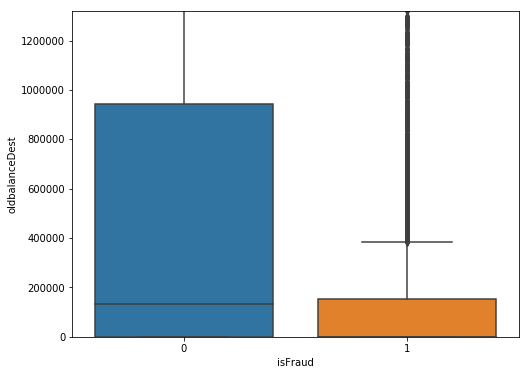

In [19]:
# Plot Step 
col = 'oldbalanceDest'
plt.figure(figsize=FIGSIZE)
sns.boxplot(data=tmp_data,x='isFraud',y=col)
plt.ylim(
    tmp_data.loc[isFraud,col].quantile(0.2),
    tmp_data.loc[~isFraud,col].quantile(0.8)
)
plt.show();

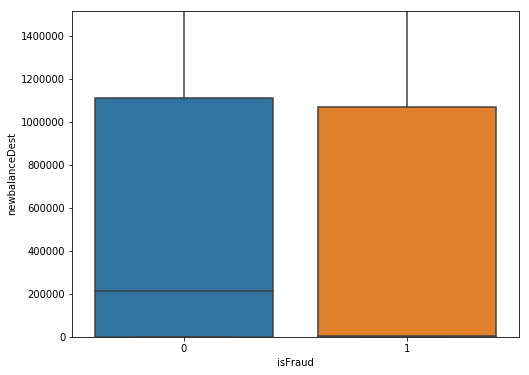

In [20]:
# Plot Step 
col = 'newbalanceDest'
plt.figure(figsize=FIGSIZE)
sns.boxplot(data=tmp_data,x='isFraud',y=col)
plt.ylim(
    tmp_data.loc[isFraud,col].quantile(0.2),
    tmp_data.loc[~isFraud,col].quantile(0.8)
)
plt.show();

From the above box plots, no surprises here, but the account of a fraudulent activity is typically much higher than the average prior to sending the money out while the destination account is typically has less than average balance in it to start. This could potentially indicate the thefts target higher amount accounts with dummy accounts.

#### Evaluation of the categorical variables

In [21]:
categorical_features = X_train.select_dtypes('object').columns.tolist()
categorical_features.append('isFlaggedFraud')
print('Categorical Variables:',categorical_features)

Categorical Variables: ['type', 'nameOrig', 'nameDest', 'isFlaggedFraud']


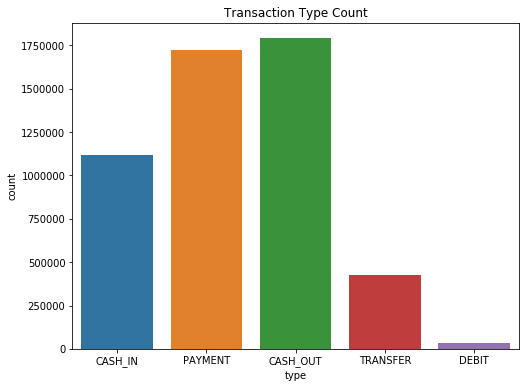

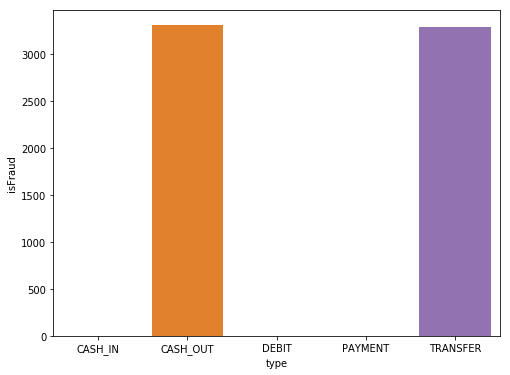

In [22]:
# Visualizing inspecting the transaction types
plt.figure(figsize=FIGSIZE)
sns.countplot(X_train['type']);
plt.title('Transaction Type Count')
plt.show();

# What type of transactions are the scammers involved in
type_to_fraud = X_train.join(y_train).groupby(['type']).sum()['isFraud']
type_to_fraud = type_to_fraud.reset_index()

plt.figure(figsize=FIGSIZE)
sns.barplot(x='type',y='isFraud',data=type_to_fraud)
plt.show();

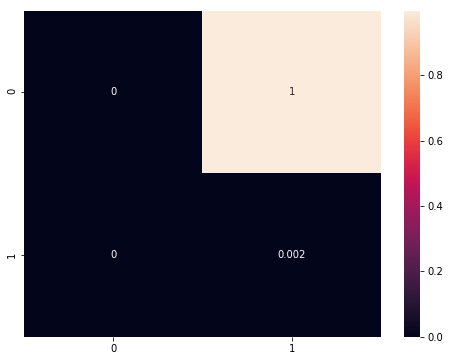

In [23]:
# Inspection of isFlaggedFraud 
# Of all actual frauds, how often does isFlaggedFraud catches it 
isFraud = y_train==1
cm = confusion_matrix(X_train.loc[isFraud,'isFlaggedFraud'],y_train[isFraud])

plt.figure(figsize=FIGSIZE)
sns.heatmap(cm/cm.sum(),annot=True)
plt.show();

Can see from the above, the isFraudFlagged indicator (indicator of a large transaction) does not do a very good job at predicting whether a transaction is fraud as indicated by the percentage of actual fraud captured of 0.2%.

#### Observations
- No missing data
- The number of fraudulent activities is very small, 0.13%. This might suggest some class balancing.
- Fraudulent activities were either CASH-OUT or TRANSFER which should come to no surprise.
- Account balances of sender and recipients before and after transaction are highly related and so we may not need both columns
- Accounts that are typically targeted are those with higher than average balances in them
- Accounts that receive the funds are typically accounts with lower than average balances
- Transactions with 0 amount were all fraudulent.
- There were many more source accounts than destination accounts
- The amount variables have very large ranges indicating some transformation of the data may be necessary

#### Feature Selection

We are going to be performing some feature selection on the numerical variables. For categorical variables we will use only type while the account in which they come from will be dropped. Reason being, we see the typ may play a factor and while the account may also as well, given the large number of accounts, it may not be a very useful feature. 

We first select the number of features to use using Principal Component Analysis

In [24]:
numerical_features = ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']
array = X_train.loc[:,numerical_features]
pca = PCA(n_components=4)
fit = pca.fit(array)
print(f'{fit.explained_variance_ratio_}')
print(f'Variance captures by top 2: {100*sum(fit.explained_variance_ratio_[:2]):0.1f}%')

[0.5893913  0.39630117 0.01283007 0.00124136]
Variance captures by top 2: 98.6%


We can see two features account for 98.6% of variation, so we will take the top two features. To determine the top 2 features I use decision trees to derive feature importance.

In [25]:
etc = ExtraTreesClassifier(n_estimators=10)
etc.fit(X_train.loc[:,numerical_features],y_train)
print('Feature Importance:')
for i in range(len(numerical_features)):
    print(f'{numerical_features[i]:<20}|{etc.feature_importances_[i]:0.3f}')

Feature Importance:
step                |0.183
amount              |0.207
oldbalanceOrg       |0.335
newbalanceOrig      |0.094
oldbalanceDest      |0.053
newbalanceDest      |0.128


## Preprocessing

From the previous observations there were a few things we are going to attempt to put into the model. The **type** variable is an important factor as it only 2 type of transactions are part of fraud. The other categorical variables appears to be not necessary as they are the account numbers. Next given the large range of some of the columns we are going to scale these features as certain models such as logistics regression perform worse otherwise. We will use normalization over standardization given the large amount of outliers, it'll likely still have large values. Finally, with the low event rate of a fraud, we are going to use SMOTE to balance the classes.

Things we will do below:
- Feature Engineer
    - Encode the type columns 
- Normalize numerical features 
- Balance the classes using SMOTE
- Remove unused columns 

In [26]:
def process(X,y,smote,remove_features=[]): 
    
    X_ = X.copy()
    y_ = y.copy()
    
    # Encode the labels 
    ohe = OneHotEncoder().fit(X_['type'].values.reshape(-1,1))
    ohe_df = pd.DataFrame(
        ohe.transform(X_['type'].values.reshape(-1,1)).toarray(),
        columns=ohe.categories_[0],
        index=X_.index
    )
    X_ = X_.join(ohe_df)
    
    # Normalization of data
    numerical_features = X_.select_dtypes(exclude='object').columns.tolist()
    numerical_features.remove('isFlaggedFraud')    

    mms = MinMaxScaler()
    mms.fit(X_.loc[:,numerical_features])
    X_.loc[:,numerical_features] = pd.DataFrame(
        mms.transform(X_.loc[:,numerical_features]),
        columns=numerical_features,
        index=X_.index
    )
        
    # Drop unused features
    X_.drop(remove_features,axis=1,inplace=True)
    
    # Class Balancing 
    if smote: 
        smo = SMOTE(random_state=42)
        X_df, y_df = smo.fit_sample(X_,y_)
        X_df = pd.DataFrame(X_df,columns=X_.columns)
        y_df = pd.Series(y_df,name=y_.name)
        return X_df,y_df
    else: 
        return X_, y_

In [27]:
features_to_remove = ['type','nameOrig','nameDest','step','newbalanceOrig','oldbalanceDest','newbalanceDest']
X_train2,y_train2 = process(X_train,y_train,True,features_to_remove)

/Users/dominicjo/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## Model

#### Training Data

In [28]:
model = LogisticRegression(solver='lbfgs')
model.fit(X_train2,y_train2);

In [29]:
print(f'Mean Score on Training Set: {np.mean(cross_val_score(model,X_train2,y_train2,cv=4)):0.2f}');

/Users/dominicjo/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Mean Score on Training Set: 0.91


In [30]:
# Training Data
y_train2_pred = model.predict(X_train2)
y_train2_prob = model.predict_proba(X_train2)
y_train2_prob = np.array([x[1] for x in y_train2_prob])

In [31]:
# Confusion Matrix
cm = confusion_matrix(y_train2_pred,y_train2)
cm

array([[4715410,  527090],
       [ 368093, 4556413]])

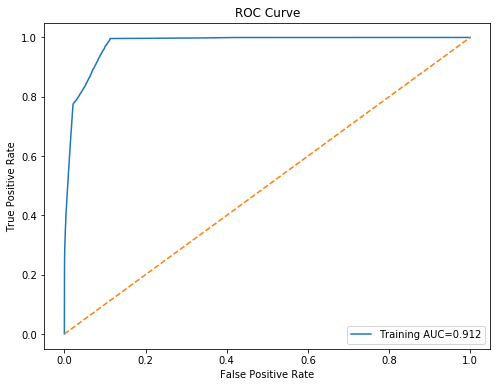

In [32]:
# ROC Curve 
# Training Data
fp_train2, tp_train2, threshold = roc_curve(y_train2,y_train2_prob,pos_label=1)
auc_train2 = roc_auc_score(y_train2,y_train2_pred)

# Plot
plt.figure(figsize=FIGSIZE)
ax = plt.gca()
plt.plot(fp_train2,tp_train2,label=f'Training AUC={auc_train2:0.3f}')
plt.legend()

plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# 50% line
plt.plot(fp_train2,fp_train2,label='AUC=0.5',linestyle='--')

plt.show();

The results so far is pretty good, but from the above feature importance, we also noticed step and amount having very similar feature importance. I'm going to try and improve the model once by setting a higher threshold for the PCA analysis of 99% explained variance ratio. This will lead to a 3 factors being included in the model. 

In [33]:
features_to_remove = ['type','nameOrig','nameDest','newbalanceOrig','oldbalanceDest','newbalanceDest']
X_train3,y_train3 = process(X_train,y_train,True,features_to_remove)

model2 = LogisticRegression(solver='lbfgs')
model2.fit(X_train3,y_train3)

/Users/dominicjo/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [44]:
print(f'Mean Score on Training Set: {np.mean(cross_val_score(model2,X_train3,y_train3,cv=4)):0.2f}');

/Users/dominicjo/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Mean Score on Training Set: 0.92


In [35]:
# Training Data
y_train3_pred = model2.predict(X_train3)
y_train3_prob = model2.predict_proba(X_train3)
y_train3_prob = np.array([x[1] for x in y_train3_prob])

In [36]:
# Confusion Matrix
cm = confusion_matrix(y_train3_pred,y_train3)
cm

array([[4712467,  404924],
       [ 371036, 4678579]])

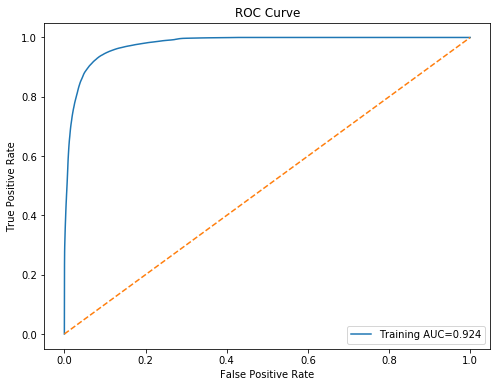

In [37]:
# ROC Curve 
# Training Data 3
fp_train3, tp_train3, threshold = roc_curve(y_train3,y_train3_prob,pos_label=1)
auc_train3 = roc_auc_score(y_train3,y_train3_pred)

# Plot
plt.figure(figsize=FIGSIZE)
ax = plt.gca()
plt.plot(fp_train3,tp_train3,label=f'Training AUC={auc_train3:0.3f}')
plt.legend()

plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# 50% line
plt.plot(fp_train3,fp_train3,label='AUC=0.5',linestyle='--')

plt.show();

There does not appear to be a large improvement adding in the additional feature as the accuracy is still about 92% while the AUC score slightly increases to 0.92 from 0.91. As a result we will opt for the simpler model, of only two numerical variables and the one hot encoded type variable. Overall results are still promising being above 90%.

#### Testing

In [38]:
# Preparing the testing data
features_to_remove = ['type','nameOrig','nameDest','step','newbalanceOrig','oldbalanceDest','newbalanceDest']
X_test2,y_test2 = process(X_test,y_test,False,features_to_remove)

/Users/dominicjo/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [45]:
print(f'Mean Score on Test Set: {np.mean(cross_val_score(model,X_test2,y_test2,cv=4)):0.2f}');

Mean Score on Test Set: 1.00


In [46]:
# Test Data
y_test2_pred = model.predict(X_test2)
y_test2_prob = model.predict_proba(X_test2)
y_test2_prob = np.array([x[1] for x in y_test2_prob])

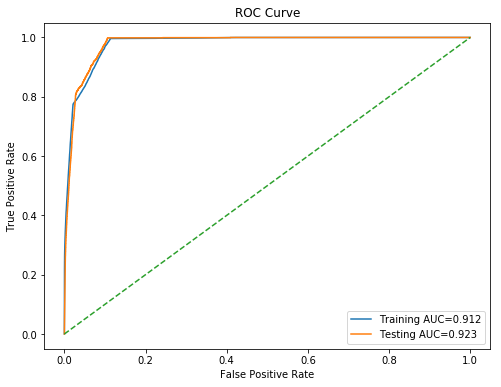

In [47]:
# ROC Curve 

# Test Data
fp_test2, tp_test2, threshold = roc_curve(y_test2,y_test2_prob,pos_label=1)
auc_test2 = roc_auc_score(y_test2,y_test2_pred)

# Plot
plt.figure(figsize=FIGSIZE)
ax = plt.gca()
plt.plot(fp_train2,tp_train2,label=f'Training AUC={auc_train2:0.3f}')
plt.plot(fp_test2,tp_test2,label=f'Testing AUC={auc_test2:0.3f}')
plt.legend()

plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# 50% line
plt.plot(fp_train2,fp_train2,label='AUC=0.5',linestyle='--')

plt.show();

## Discussion and Conclusion

In [48]:
# Final parameters

In [81]:
print('Final Model Summary: Logistic Regression')
print('-'*80)
print('intercept           |   -96.7')
for var,coef in zip(X_train2.columns,model.coef_[0]):
    print(f'{var:<20}|{coef:>8.1f}')

Final Model Summary: Logistic Regression
--------------------------------------------------------------------------------
intercept           |   -96.7
amount              |  -334.9
oldbalanceOrg       |   511.8
isFlaggedFraud      |     0.8
CASH_IN             |  -182.0
CASH_OUT            |    96.2
DEBIT               |     0.8
PAYMENT             |   -24.0
TRANSFER            |    97.9


Overall results are quite good as indicated by the ROC Curve and the accuracy. Earlier the PCA method indicated only two variables should be used despite the decision tree indicating feature importance of three variables. This could likely be from the the data being non-linear and some transformation on the data might be useful to apply on it first. Regardless though, the overall performance is quite good with the training set and ROC Curve at about 90%. The cross validated with 4 folds shows a close to 100% accuracy on the test set which is an indication the testing set size may be too small for the data given the lack of balancing on the testing data.